<a href="https://colab.research.google.com/github/xavier-404/FMML-2022-ASSIGNMENTS/blob/main/Copy_of_FMML_Module4_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOUNDATIONS OF MODERN MACHINE LEARNING, IIIT Hyderabad
# Module 4
## Lab 4: Support Vector Machines
### Module Coordinator: Jashn Arora


In [ ]:
#Importing the necessary packages
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import pandas
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt



The topic of classifier in today's lab, SVMs make for really good linear separators. Let us look at an example which has linearly separable data:

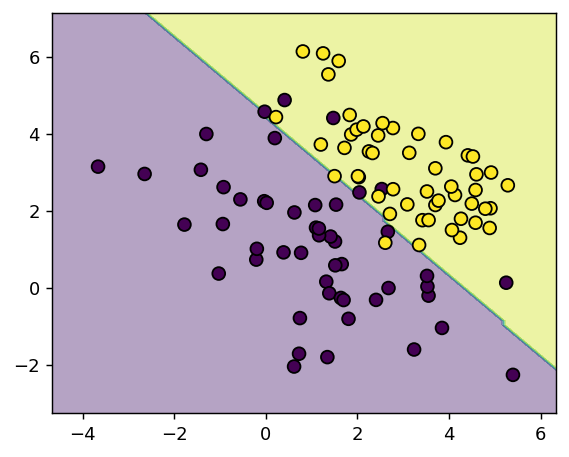

In [12]:
np.random.seed(0)

ar = np.vstack(     [\
                    np.random.multivariate_normal(np.array([1, 1]), 1.5 * np.array([[2, -1], [-1, 2.0]]), size = 50, ),\
                    np.random.multivariate_normal(np.array([3, 3]), 2 * np.array([[0.75, -0.5], [-0.5, 0.75]]), size = 50, )
                    ]\
              )

testAr = np.vstack(   [\
                      np.random.multivariate_normal(np.array([1, 1]), np.array([[0.5, -0.25], [-0.25, 0.5]]), size = 500, ),\
                      np.random.multivariate_normal(np.array([3, 3]), np.array([[0.75, -0.5], [-0.5, 0.75]]), size = 500, )
                      ]\
                  )
testy = np.array([0] * int((testAr.shape[0]/2)) + [1] * int((testAr.shape[0]/2)))

X = ar
y = np.array([0] * int((ar.shape[0]/2)) + [1] * int((ar.shape[0]/2)))

def plotDecisionBoundary(X, y, pair, clf):
  x_min, x_max = X[:, pair[0]].min() - 1, X[:, pair[0]].max() + 1
  y_min, y_max = X[:, pair[1]].min() - 1, X[:, pair[1]].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))
  
  y_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  y_pred = y_pred.reshape(xx.shape)
  plt.figure(figsize=(5,4))
  plt.contourf(xx, yy, y_pred, alpha=0.4)
  plt.scatter(X[:, pair[0]], X[:, pair[1]], c = y, s = 50, edgecolor='k')
  # plt.legend()
  plt.gcf().set_dpi(130)
  plt.show()

def boundaryExp() :
  clf = svm.LinearSVC()
  pair = [0, 1]
  clf.fit(X[:, pair], y)
  plotDecisionBoundary(X, y, pair, clf)

  plt.show()

boundaryExp()

## Intuitive introduction to SVMs:

![SVM](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526288453/index3_souoaz.png)

SVMs are an iterative approach of trying to find the optimal hyperplane that divides the multidimentional space into different classes present in the dataset.


**Hyperplanes:** These are the decision planes that separate the objects of classes that we are trying to classify.

**Support Vectors** : Support vectors are the points from dataset that are closest to the hyperplane that divides the dataset.

**Margin**:  The gap between the closest support vectors from the different class along the direction perpendicular to the hyperplane. Simply put, it is the sum of perpendicular distance of the support vector of each class to the hyperplane.

---

Let us try to fall back to the well known dataset and see how SVMs perform on the iris dataset

In [13]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
irisData = pandas.DataFrame(\
    data = np.hstack((X,y.reshape(y.shape[0], 1), [[iris["target_names"][int(classIdx)]] for classIdx in y])), \
    columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', "Class", "ClassName"])
irisData.sample(n = 10, random_state = 1)

,sepal_length,sepal_width,petal_length,petal_width,Class,ClassName
14,5.8,4.0,1.2,0.2,0,setosa
98,5.1,2.5,3.0,1.1,1,versicolor
75,6.6,3.0,4.4,1.4,1,versicolor
16,5.4,3.9,1.3,0.4,0,setosa
131,7.9,3.8,6.4,2.0,2,virginica
56,6.3,3.3,4.7,1.6,1,versicolor
141,6.9,3.1,5.1,2.3,2,virginica
44,5.1,3.8,1.9,0.4,0,setosa
29,4.7,3.2,1.6,0.2,0,setosa
120,6.9,3.2,5.7,2.3,2,virginica


In [ ]:
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the decision tree on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_pred, y_test)))
class_names = iris["target_names"]
print("The confusion matrix is : ")
plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names)

Now lets again try to see how does SVM perform when we give it just two of the features from the dataset

In [ ]:
clf = svm.LinearSVC()
pair = [2, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [2, 3], clf)

In [ ]:
clf = svm.LinearSVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

#### Alas! We see that SVMs are not able to classify the data in the above experiment because the data is not **linearly separable**

Thankfully, We have a neat trick up our sleeves that will help us to solve these problems. Let us take a look at a typical example that is used to illustrate this trick before we get back to the above dataset.

---

# The Kernel Trick

The true potential of SVMs is unleashed when they are combined with kernels.

## Kernels : An intuitive explanation

Kernel methods are essentially counting on using the training data (say $i^{th}$ example $(x_i, y_i)$ ) itself in a more straightforward way and learning a corresponding weight ($w_i$) for that example. Rather than trying to learn a fixed set of parameters which is done typically.
Depending on the kind of kernel used, we can virtually project the training data in a higher dimension to make it easier for the classifier to classify them.


In [ ]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(200, factor=.1, noise=.1)

clf = svm.SVC(kernel='linear').fit(X, y)

plt.style.use("seaborn")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='tab20')
plt.gcf().set_dpi(110)

In [ ]:
plt.style.use("default")
clf = svm.LinearSVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [0, 1], clf)

However, if we artificially add another dimention to the dataset of the form:

$z = x^2 + y^2$
we can clearly see a hyperplane that can distinguish both the datasets:

In [ ]:
Z = np.array([[i[0]**2 + i[1]**2] for i in X])

In [ ]:
X_new = np.hstack((X, Z))

In [ ]:
import plotly.graph_objects as go


In [ ]:
fig = go.Figure(data = [go.Scatter3d(
    x = X_new[:, 0],
    y = X_new[:, 1],
    z = X_new[:, 2],
    mode = "markers",
    marker = {
        "color" : y,
        "line": {"width" : 4, "color":'DarkSlateGrey'},
        "colorscale": "viridis"},
)])

fig.show()

That simple trick has helped us to get another dimension in which the data is linearly separable by a hyperplane (in this case, a 2d plane)

---

Now let us use the rbf kernel and use an SVM Classifier.

In [ ]:
plt.style.use("default")
clf = svm.SVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [0, 1], clf)

Now let us get back to our original dataset of iris and see if this kernel trick has helped us:

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the decision tree on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_pred, y_test)))
class_names = iris["target_names"]
print("The confusion matrix is : ")
plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names)

Certainly, using a kernel has increased our accuracy on the iris dataset.

Things to try out:
- Try to run the same experiment after filtering different features, 2 at a time.
- Using different kinds of kernels for the SVM among: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

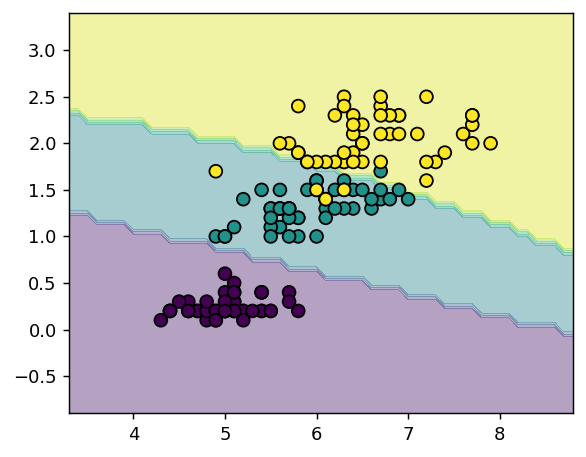

In [18]:
# Q. Try to run the same experiment after filtering different features, 2 at a time.
# Answer:
# sepal_length and petal_width

from sklearn.metrics import classification_report
     

plt.style.use("default")
clf = svm.SVC()
pair = [0, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

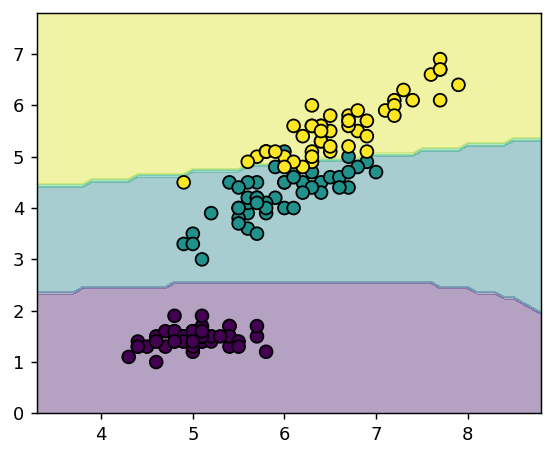

In [19]:
# sepal_length and petal_length

plt.style.use("default")
clf = svm.SVC()
pair = [0, 2]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)
     

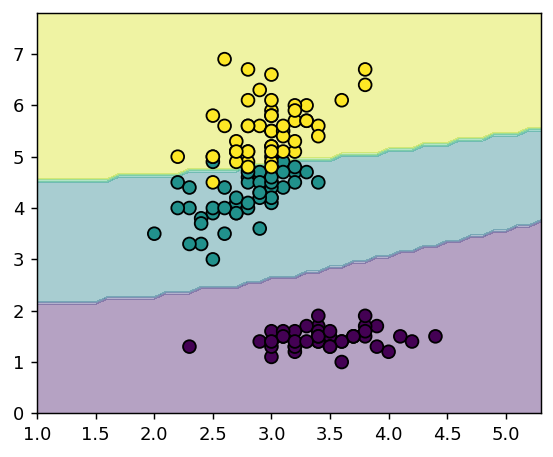

In [20]:
# sepal_width and petal_length

plt.style.use("default")
clf = svm.SVC()
pair = [1, 2]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

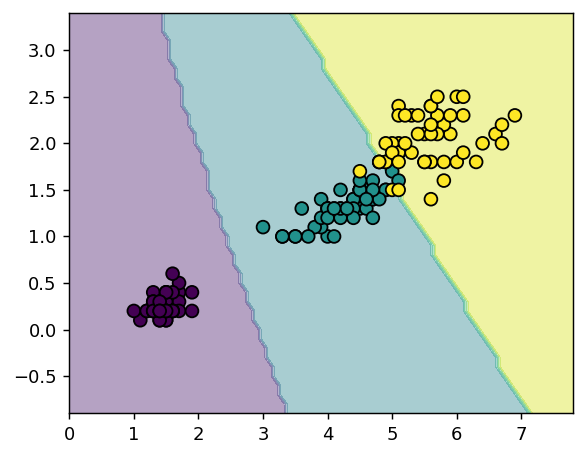

In [21]:
# petal_length and petal_width

plt.style.use("default")
clf = svm.SVC()
pair = [2, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)
     

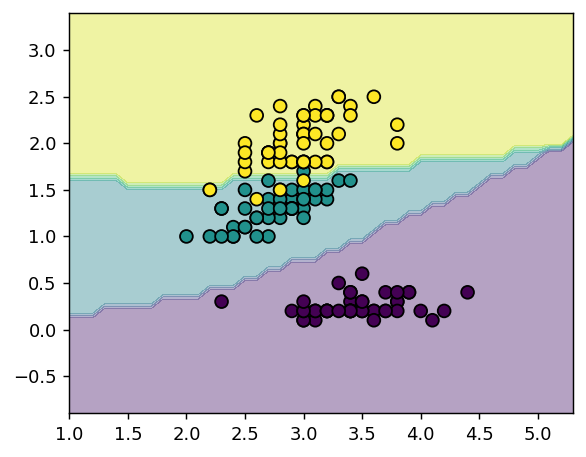

In [22]:
# sepal_width and petal_width

plt.style.use("default")
clf = svm.SVC()
pair = [1, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

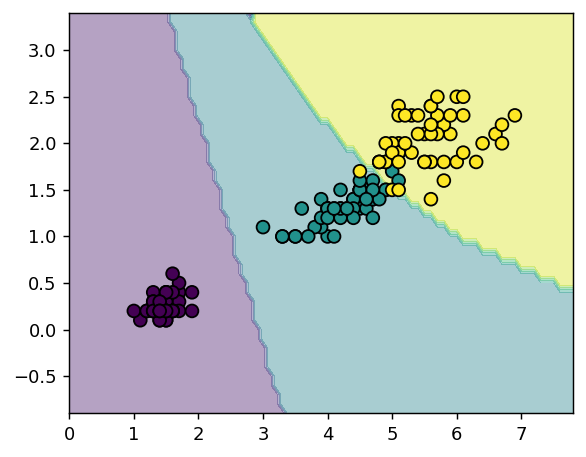

In [23]:
# Q. Using different kinds of kernels for the SVM among: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
# Answer:

from sklearn.metrics import classification_report
import warnings as warn
warn.filterwarnings("ignore")
     

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
     

## petal_length and petal_width - "poly" kernel

plt.style.use("default")
clf = svm.SVC(kernel="poly")
pair = [2, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

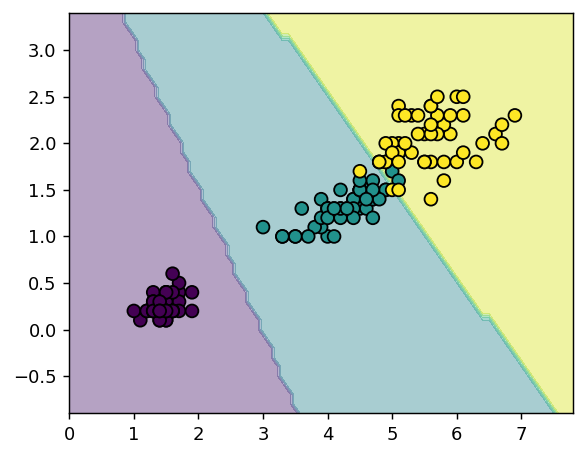

In [24]:
## petal_length and petal_width - "linear" kernel

plt.style.use("default")
clf = svm.SVC(kernel="linear")
pair = [2, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)
     

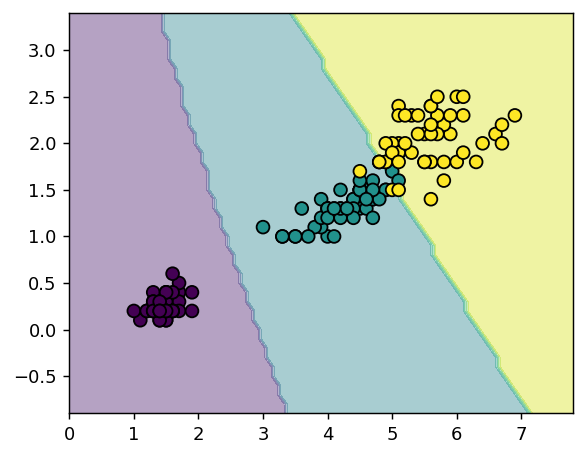

In [25]:

## petal_length and petal_width - "rbf" kernel

plt.style.use("default")
clf = svm.SVC(kernel="rbf")
pair = [2, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

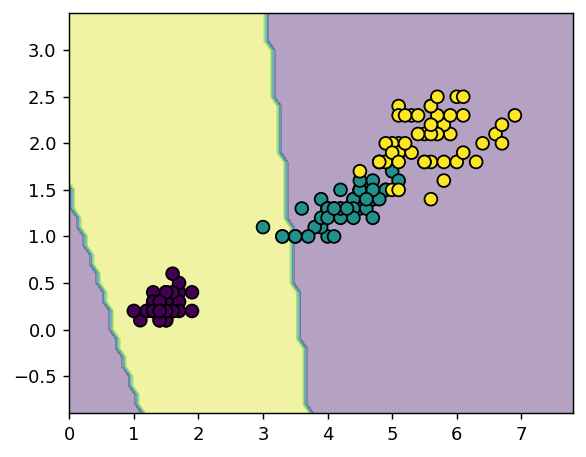

In [26]:

## petal_length and petal_width - "sigmoid" kernel

plt.style.use("default")
clf = svm.SVC(kernel="sigmoid")
pair = [2, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

In [ ]:
# linear kernel

clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the SVC on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_test, y_pred)))
class_names = iris["target_names"]
print("The classification report is :\n",classification_report(y_test,y_pred))
print("The confusion matrix is : ")
plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names)

In [ ]:
# poly kernel

clf = svm.SVC(kernel="poly")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the SVC on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_test, y_pred)))
class_names = iris["target_names"]
print("The classification report is :\n",classification_report(y_test,y_pred))
print("The confusion matrix is : ")
plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names)

In [ ]:
# rbf kernel

clf = svm.SVC(kernel="rbf")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the SVC on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_test, y_pred)))
class_names = iris["target_names"]
print("The classification report is :\n",classification_report(y_test,y_pred))
print("The confusion matrix is : ")
plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names)

In [ ]:
# sigmoid kernel

clf = svm.SVC(kernel="sigmoid")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the SVC on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_test, y_pred)))
class_names = iris["target_names"]
print("The classification report is :\n",classification_report(y_test,y_pred))
print("The confusion matrix is : ")
plot_confusion_matrix(clf, X_test, y_test, display_labels=class_names)
     

In [ ]:
# precomputed kernel

clf = svm.SVC(kernel="precomputed")
X_train_gram=np.dot(X_train,X_train.T)
clf.fit(X_train_gram, y_train)
X_test_gram=np.dot(X_test,X_train.T)
y_pred = clf.predict(X_test_gram)
print("Accuracy of the SVC on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_test, y_pred)))
class_names = iris["target_names"]
print("The classification report is :\n",classification_report(y_test,y_pred))
print("The confusion matrix is : ")
plot_confusion_matrix(clf, X_test_gram, y_test, display_labels=class_names)

End of Lab 4

---

Helpful References and sources:

- https://datamites.com/blog/support-vector-machine-algorithm-svm-understanding-kernel-trick/
- https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
- https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
